In [1]:
import pandas as pd
import numpy as np

In [2]:
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
import math
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.filterwarnings('ignore')

### Loading the data

In [3]:
high_price=pd.read_csv("daily_high.csv")
high_price

,Date,High_Price
0,2016-01-01,1020.000
1,2016-01-02,1010.675
2,2016-01-03,1010.675
3,2016-01-04,1014.200
4,2016-01-05,1010.000
...,...,...
2491,2022-10-27,2468.000
2492,2022-10-28,2534.000
2493,2022-10-29,2530.500
2494,2022-10-30,2530.500


### Making index into date format and droping the redundant date column

In [4]:
high_price.Date=pd.to_datetime(high_price.Date)
high_price.index=high_price.Date
high_price.drop(['Date'],axis=1,inplace=True)
high_price

,High_Price
Date,
2016-01-01,1020.000
2016-01-02,1010.675
2016-01-03,1010.675
2016-01-04,1014.200
2016-01-05,1010.000
...,...
2022-10-27,2468.000
2022-10-28,2534.000
2022-10-29,2530.500


In [5]:
from pandas.plotting import lag_plot

### lag plot with a lag of 365

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 365)'>

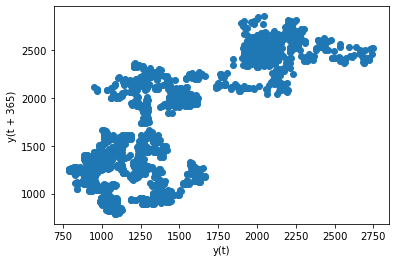

In [6]:
lag_plot(high_price.High_Price,lag=365)


### Line plot of the data

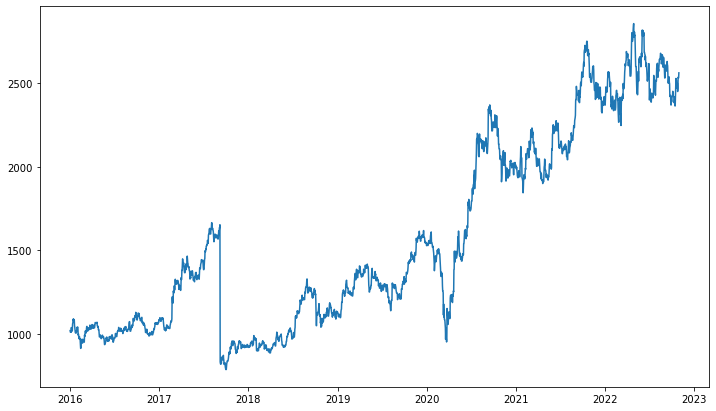

In [7]:
plt.figure(figsize=(12,7))
plt.plot(high_price.High_Price)

### 365 days moving average of the data

<AxesSubplot:xlabel='Date'>

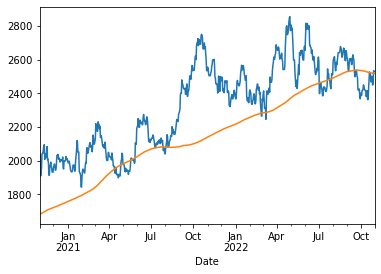

In [8]:
high_price.High_Price[-730:-1].plot(label="org")
high_price.High_Price.rolling(365).mean()[-730:-1].plot(label=str(365))

### Taking the last 90 days as test data.

In [9]:
a=-90
train=high_price.iloc[:a,:]
test=high_price.iloc[a:,:]
Train=train.copy()

### Augmented Dickey Fuller Test for stationarity is done on the original data

In [10]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(high_price, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   -0.916593
p-value                           0.782459
#Lags Used                       21.000000
Number of Observations Used    2474.000000
Critical Value (1%)              -3.432996
Critical Value (5%)              -2.862709
Critical Value (10%)             -2.567392
dtype: float64


### From the dickey-fuller test it can be seen that the data is not stationary

### Exponential weighted moving average of the data with a halflife of 30 days

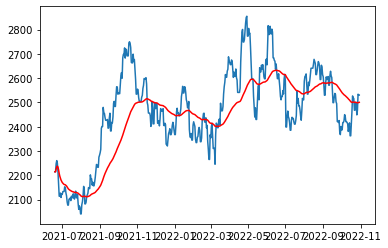

In [11]:
expwighted_avg =high_price[-500:-1].ewm(halflife=30).mean()
plt.plot(high_price[-500:-1])
plt.plot(expwighted_avg, color='red')

### Decomposition plot of the data with a seasonal period of 365 days

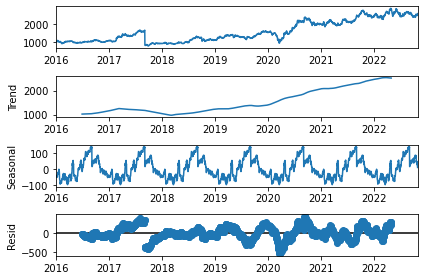

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(high_price,period=365)
decompose_ts_add.plot()
plt.show()

### ACF and PACF plots of the original data

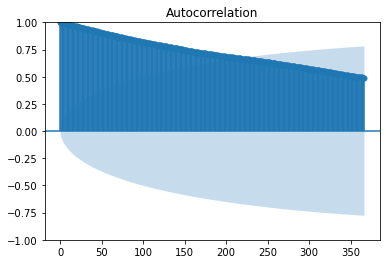

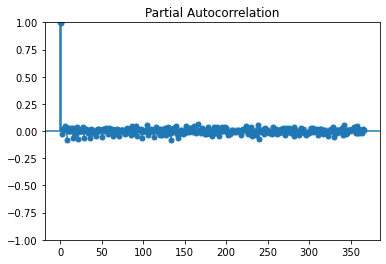

In [13]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(high_price,lags=366)
tsa_plots.plot_pacf(high_price,lags=366)
plt.show()

### It can be seen that auto-correlation become insignificant at above 200 lag and PACF become insignifant at lag 1.

In [14]:
train

,High_Price
Date,
2016-01-01,1020.000
2016-01-02,1010.675
2016-01-03,1010.675
2016-01-04,1014.200
2016-01-05,1010.000
...,...
2022-07-29,2517.000
2022-07-30,2510.875
2022-07-31,2510.875


### Seasonal differencing and then a further trend differencing is done on that.

In [15]:
train['seasonal_diff']=train.High_Price-train.High_Price.shift(365)
train['trend_diff']=train.High_Price-train.High_Price.shift()
train['seasonal_trend_diff']=train.trend_diff-train.trend_diff.shift(365)
train

,High_Price,seasonal_diff,trend_diff,seasonal_trend_diff
Date,,,,
2016-01-01,1020.000,NaN,NaN,NaN
2016-01-02,1010.675,NaN,-9.325,NaN
2016-01-03,1010.675,NaN,0.000,NaN
2016-01-04,1014.200,NaN,3.525,NaN
2016-01-05,1010.000,NaN,-4.200,NaN
...,...,...,...,...
2022-07-29,2517.000,442.600,50.000,35.750
2022-07-30,2510.875,442.725,-6.125,0.125
2022-07-31,2510.875,469.575,0.000,26.850


In [16]:
train.dropna(inplace=True)

### Line lot of the seasonally differenced data

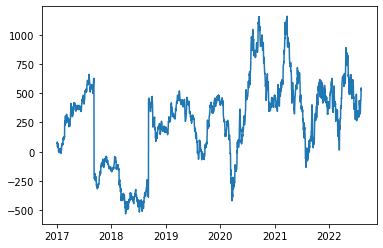

In [17]:
plt.plot(train.seasonal_diff)

### Dickey-Fuller test of the seasonally differenced data

In [18]:
dftest = adfuller(train.seasonal_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   -3.205570
p-value                           0.019665
#Lags Used                       21.000000
Number of Observations Used    2018.000000
Critical Value (1%)              -3.433595
Critical Value (5%)              -2.862973
Critical Value (10%)             -2.567533
dtype: float64


### It can be seen that the seasonally differenced data is stationary with more than 98% confidence.

### Adfuller test of the seasonally and trend differenced data

In [19]:
dftest = adfuller(train.seasonal_trend_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -8.519605e+00
p-value                        1.109846e-13
#Lags Used                     2.000000e+01
Number of Observations Used    2.019000e+03
Critical Value (1%)           -3.433593e+00
Critical Value (5%)           -2.862973e+00
Critical Value (10%)          -2.567533e+00
dtype: float64


### It can be seen that this series is stationary with more than 99% confidence.

### lot of the seasonally and trend differenced data

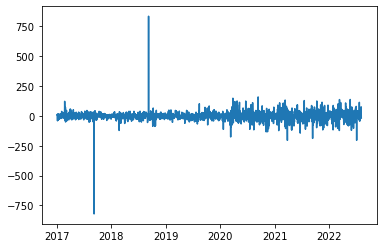

In [20]:
plt.plot(train.seasonal_trend_diff)

### ACF and PACF plots of the seasonally differenced data

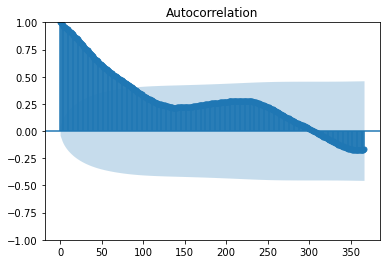

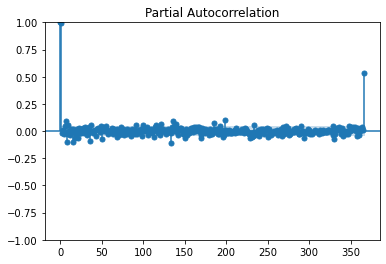

In [21]:
tsa_plots.plot_acf(train.seasonal_diff,lags=366)
tsa_plots.plot_pacf(train.seasonal_diff,lags=366)
plt.show()

### Auto correlation become insignificant at around 80 lag and PACF becomes insignificant at lag 2. PACF also shows positive correlation at lag 366, for a sarima model it might indicate an SAR term.

### ACF and PACF plots of seasonally and trend differenced data. both become insignificant at lag 1. Both show a negative correlation at lag 366. Indicating a SMA term for sarima

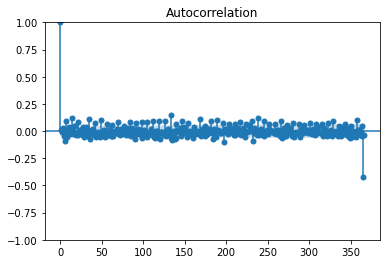

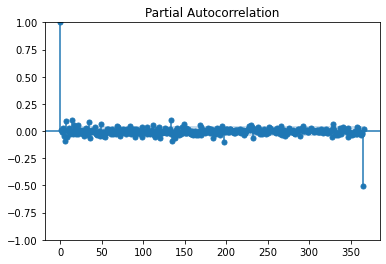

In [22]:
tsa_plots.plot_acf(train.seasonal_trend_diff,lags=366)
tsa_plots.plot_pacf(train.seasonal_trend_diff,lags=366)
plt.show()

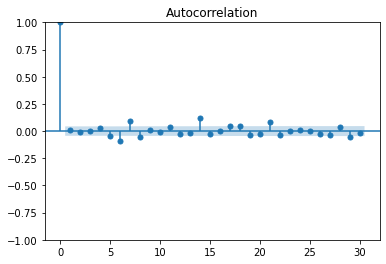

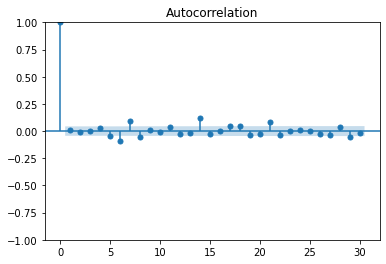

In [23]:
tsa_plots.plot_acf(train.seasonal_trend_diff,lags=30)

In [24]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

## Model Building

### Defining a class to store model details and errors for comparing

In [44]:
class Model_Store:
    def __init__(self,model,test,name,column='High_Price'):
        pred=model.forecast(len(test))
        if column!='High_Price':
            test['forecast']=pred
            last_year=train.High_Price[-365:]
            new_pred=[]
            for i in enumerate(test.index):
                new_pred.append(last_year[i[0]]+test.loc[i[1],'forecast'])
            test['predictions']=new_pred
        else:
            test['predictions']=pred
        
        self.mae=mean_absolute_error(test.High_Price,test.predictions)
        self.rmse=np.sqrt(mean_squared_error(test.High_Price,test.predictions))
        self.mape=mean_absolute_percentage_error(test.High_Price,test.predictions)
        self.name=name
        self.model=model
        self.test=test
        
    def plot(self):
        plt.plot(self.test['High_Price'],color='red')
        plt.plot(self.test['predictions'],color='green')
        plt.legend(['original data','predictions'])
    def calculate_errors(self):
        print('mae : ',self.mae)
        print('mape : ',self.mape)
        print('rmse : ',self.rmse)

            
            
            
            

### Definig a function to find minimum error for a number of given models for the purpose of hyper-parameter tuning.

In [45]:
def mini(ls):
    mi=ls[0]
    new_ls=[]
    for i in ls:
        if i.mae<=mi.mae:
            mi=i
        new_ls.append(i.mae)
    print(mi.name,":",mi.mae)

In [46]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 

### Simeple Exponential smoothing

### Hyper-parameter tuning

In [47]:
ls=[]
for i in np.arange(0,1,0.05):
    ses_model = SimpleExpSmoothing(Train["High_Price"]).fit(smoothing_level=i)
    ses=Model_Store(ses_model,test,str(i))
    ls.append(ses)
mini(ls)

0.25 : 79.21064707709546


### Model built using smoothing level=0.25

mae :  79.21064707709546
mape :  0.03155983618312756
rmse :  92.02206120002845


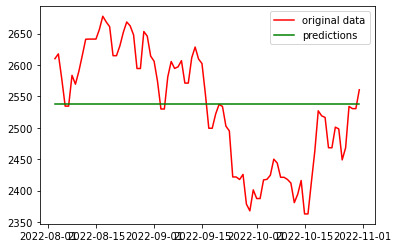

In [48]:
ses_actual=SimpleExpSmoothing(Train["High_Price"]).fit(smoothing_level=0.25)
ses=Model_Store(ses_actual,test,'ses')
ses.plot()
ses.calculate_errors()

### Holt double exponential smoothing

### Hyper-parameter tuning

In [49]:
from statsmodels.tsa.holtwinters import Holt
ls=[]
for i in np.arange(0,1,0.01):
    for j in np.arange(0,1,0.01):
        hw_model = Holt(Train["High_Price"]).fit(smoothing_level=i, smoothing_slope=j)
        hw=Model_Store(hw_model,test,str((i,j)))
        ls.append(hw)
mini(ls)

(0.04, 0.61) : 55.69971279152946


### Building a model using smoothing level=0.04 and smoothing slope=0.61

mae :  55.69971279152946
mape :  0.02224480167637012
rmse :  65.14367130178881


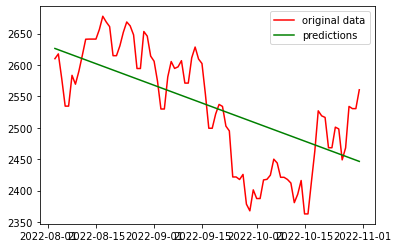

In [50]:
hw_actual = Holt(Train["High_Price"]).fit(smoothing_level=0.04, smoothing_slope=0.61)
hw=Model_Store(hw_actual,test,'hw')
hw.plot()
hw.calculate_errors()

In [32]:
train

,High_Price,seasonal_diff,trend_diff,seasonal_trend_diff
Date,,,,
2017-01-01,1080.725,70.050,0.000,9.325
2017-01-02,1089.450,78.775,8.725,8.725
2017-01-03,1097.000,82.800,7.550,4.025
2017-01-04,1092.450,82.450,-4.550,-0.350
2017-01-05,1079.500,41.500,-12.950,-40.950
...,...,...,...,...
2022-07-29,2517.000,442.600,50.000,35.750
2022-07-30,2510.875,442.725,-6.125,0.125
2022-07-31,2510.875,469.575,0.000,26.850


In [33]:
Train

,High_Price
Date,
2016-01-01,1020.000
2016-01-02,1010.675
2016-01-03,1010.675
2016-01-04,1014.200
2016-01-05,1010.000
...,...
2022-07-29,2517.000
2022-07-30,2510.875
2022-07-31,2510.875


### Holt-Winters

### Hyper-parameter tuning

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
params=('add','mul')
ls=[]
for k in params:
    for l in params:
        hwe_model=ExponentialSmoothing(Train['High_Price'],seasonal=k,trend=l,seasonal_periods=365).fit()
        hwe=Model_Store(hwe_model,test,str((k,l)))
        ls.append(hwe)

mini(ls)

('mul', 'add') : 75.06220863046856


### Building a model with multiplicative seasonality and additive trend

mae :  75.06220863046856
mape :  0.030304219848440155
rmse :  94.9692816999012


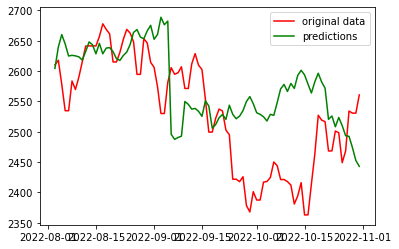

In [35]:
hwe_actual=ExponentialSmoothing(Train['High_Price'],seasonal='mul',trend='add',seasonal_periods=365).fit()
hwe=Model_Store(hwe_actual,test,'hwe')
hwe.plot()
hwe.calculate_errors()

### ARIMA

### Model is built using seasonally differenced data. an order of (2,0,80) is used since without differencing the ACF become insignificant at lag 80 and PACF become insignificant at lag 2

In [36]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['seasonal_diff'],order=(2,0,80))
results_AR=model.fit()

mae :  357.3194601407124
mape :  0.14441305395941673
rmse :  429.14345906305317


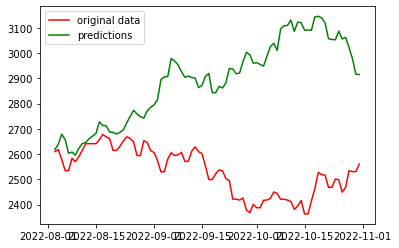

In [37]:
arima_undiff=Model_Store(results_AR,test,'arima_undiff',column='seasonal_diff')
arima_undiff.plot()
arima_undiff.calculate_errors()

### This arima model is built considering 1 order of differencing in th seasonally differenced data. SInce both ACF and PACF become insignificant at 1, an order of (1,1,1) was used.

mae :  422.86835006027945
mape :  0.17094699330784266
rmse :  510.4707729566792


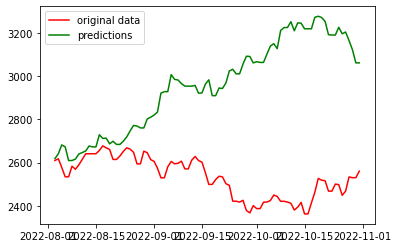

In [38]:
model2 = ARIMA(train['seasonal_diff'],order=(1,1,1))
results_AR2=model2.fit()
arima_diff=Model_Store(results_AR2,test,'arima_diff',column='seasonal_diff')
arima_diff.plot()
arima_diff.calculate_errors()

### This arima model is built with seasonality not taken into consideration an order of (1,1,1) was used

mae :  92.31419576394435
mape :  0.037530563415335894
rmse :  118.66398755298219


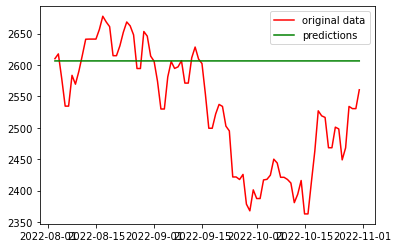

In [39]:
model3 = ARIMA(Train.High_Price,order=(1,1,1))
results_AR3=model3.fit()
arima_noseas=Model_Store(results_AR3,test,'arima_noseas')
arima_noseas.plot()
arima_noseas.calculate_errors()

### SARIMA

### model was built using an order of (1,1,1)X(0,1,1) with a seasonality of 365 days. hyper parameters were decided observing the ACF and PACF plots

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima=SARIMAX(train.High_Price,trend='n',order=(1,1,1),seasonal_order=(0,1,1,365))
results=sarima.fit(low_memory=True)


mae :  224.96574637859953
mape :  0.09114548256838388
rmse :  273.7133992798095


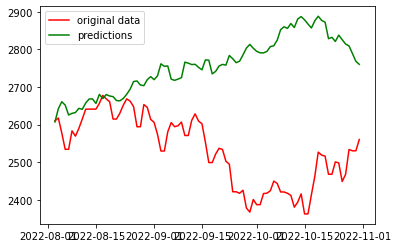

In [37]:
sarima_undiff=Model_Store(results,test,'sarima_1')
sarima_undiff.plot()
sarima_undiff.calculate_errors()

### Neural network - LSTM

### Defining a window function for use in the neural network model

In [17]:
def df_to_windowed_df(dataframe, first_date, last_date, n=3):

    target_date = first_date
  
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
    
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['High_Price'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)


        next_date = target_date+datetime.timedelta(days=1)
    
        if last_time:
            break
    
        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df

In [18]:
high_price

,High_Price
Date,
2016-01-01,1020.000
2016-01-02,1010.675
2016-01-03,1010.675
2016-01-04,1014.200
2016-01-05,1010.000
...,...
2022-10-27,2468.000
2022-10-28,2534.000
2022-10-29,2530.500


### A windowed dataframe was created to effectively convert this into supervised learning problem with window size of 5.

In [19]:
windowed_df=df_to_windowed_df(high_price,high_price.index[5],high_price.index[-1],n=5)
windowed_df

,Target Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2016-01-06,1020.000,1010.675,1010.675,1014.200,1010.000,1038.000
1,2016-01-07,1010.675,1010.675,1014.200,1010.000,1038.000,1027.600
2,2016-01-08,1010.675,1014.200,1010.000,1038.000,1027.600,1032.150
3,2016-01-09,1014.200,1010.000,1038.000,1027.600,1032.150,1017.525
4,2016-01-10,1010.000,1038.000,1027.600,1032.150,1017.525,1017.525
...,...,...,...,...,...,...,...
2486,2022-10-27,2468.225,2468.225,2501.000,2498.150,2448.925,2468.000
2487,2022-10-28,2468.225,2501.000,2498.150,2448.925,2468.000,2534.000
2488,2022-10-29,2501.000,2498.150,2448.925,2468.000,2534.000,2530.500
2489,2022-10-30,2498.150,2448.925,2468.000,2534.000,2530.500,2530.500


In [20]:
def windowed_df_to_dat_x_y(windowed_df):
    df_as_np=windowed_df.to_numpy()
    dates=df_as_np[:,0]
    mid_matrix=df_as_np[:,1:-1]
    x=mid_matrix.reshape(len(dates),mid_matrix.shape[1],1)
    y=df_as_np[:,-1]
    return dates, x.astype(np.float32), y.astype(np.float32)


In [21]:
dates, x, y = windowed_df_to_dat_x_y(windowed_df)

dates.shape, x.shape, y.shape

((2491,), (2491, 5, 1), (2491,))

### Defining validation and test dataset

In [22]:
val=len(dates)-90
tes=len(dates)-45


In [23]:
dates_train, x_train, y_train = dates[:val], x[:val], y[:val]

dates_val, x_val, y_val = dates[val:tes], x[val:tes], y[val:tes]
dates_test, x_test, y_test = dates[tes:], x[tes:], y[tes:]

### Plotting the train, validation and test dataset

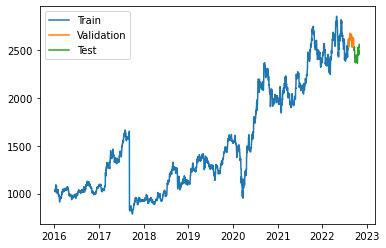

In [24]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

### Defining the model with 1 lstm layers and 3 dense layers

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((5, 1)),
                    layers.LSTM(75),
                    layers.Dense(25, activation='relu'),
                    layers.Dense(25, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
76/76 [==============================] - 4s 14ms/step - loss: 2642193.2500 - mean_absolute_error: 1527.2435 - val_loss: 6779654.5000 - val_mean_absolute_error: 2603.4893
Epoch 2/100
76/76 [==============================] - 0s 4ms/step - loss: 2597482.2500 - mean_absolute_error: 1512.4386 - val_loss: 6626743.5000 - val_mean_absolute_error: 2573.9551
Epoch 3/100
76/76 [==============================] - 0s 4ms/step - loss: 2429254.5000 - mean_absolute_error: 1455.4182 - val_loss: 6158067.0000 - val_mean_absolute_error: 2481.2437
Epoch 4/100
76/76 [==============================] - 0s 5ms/step - loss: 2048304.1250 - mean_absolute_error: 1317.4335 - val_loss: 5235797.5000 - val_mean_absolute_error: 2287.8591
Epoch 5/100
76/76 [==============================] - 0s 5ms/step - loss: 1455183.0000 - mean_absolute_error: 1068.4952 - val_loss: 3930662.5000 - val_mean_absolute_error: 1982.2118
Epoch 6/100
76/76 [==============================] - 0s 4ms/step - loss: 840271.3125 - mean_ab

76/76 [==============================] - 1s 7ms/step - loss: 1706.8962 - mean_absolute_error: 27.2146 - val_loss: 2860.9377 - val_mean_absolute_error: 47.5988
Epoch 95/100
76/76 [==============================] - 1s 8ms/step - loss: 2468.8726 - mean_absolute_error: 33.2879 - val_loss: 1337.8405 - val_mean_absolute_error: 31.5774
Epoch 96/100
76/76 [==============================] - 1s 8ms/step - loss: 2452.8193 - mean_absolute_error: 33.3104 - val_loss: 6124.2930 - val_mean_absolute_error: 73.7925
Epoch 97/100
76/76 [==============================] - 1s 8ms/step - loss: 2297.4182 - mean_absolute_error: 32.6801 - val_loss: 121084.7422 - val_mean_absolute_error: 346.9840
Epoch 98/100
76/76 [==============================] - 1s 8ms/step - loss: 6527.0454 - mean_absolute_error: 57.7856 - val_loss: 4361.4717 - val_mean_absolute_error: 60.6400
Epoch 99/100
76/76 [==============================] - 1s 8ms/step - loss: 2009.3165 - mean_absolute_error: 30.4118 - val_loss: 5519.4678 - val_mean_ab

### train predictions

76/76 [==============================] - 1s 2ms/step
29.37475


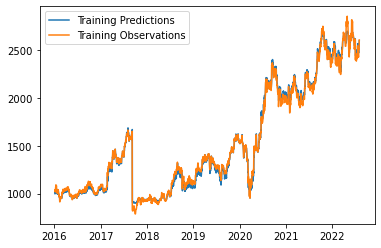

In [35]:
train_predictions = model.predict(x_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])
print(mean_absolute_error(y_train,train_predictions))

### validation predictions

2/2 [==============================] - 0s 4ms/step
22.228733


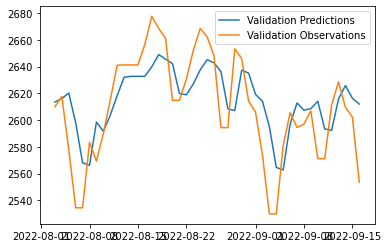

In [36]:
val_predictions = model.predict(x_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
print(mean_absolute_error(y_val,val_predictions))

### test predictions

2/2 [==============================] - 0s 2ms/step
42.14339


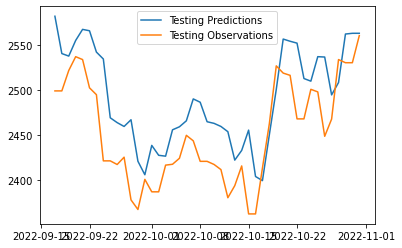

In [37]:
test_predictions = model.predict(x_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])
print(mean_absolute_error(y_test,test_predictions))

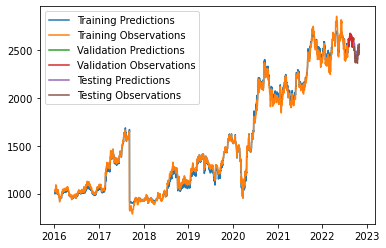

In [38]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

### Trying to recursively predict since our goal is to predict for 90 days continuously

In [39]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
    last_window = deepcopy(x_train[-1])
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction


1/1 [==============================] - 0s 18ms/step


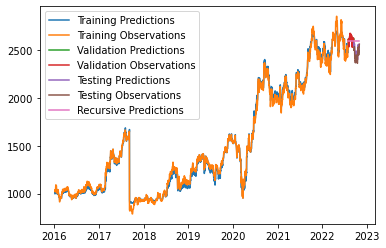

In [40]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

In [41]:
recursive_y=np.concatenate([y_val, y_test])
mean_absolute_error(recursive_y,recursive_predictions)

89.638954

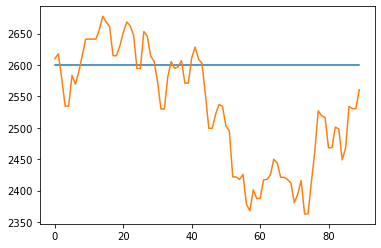

In [42]:
plt.plot(recursive_predictions)
plt.plot(recursive_y)

In [51]:
hw.model

### Saving the model with the best accuracy for deployment

In [17]:
high_price

,High_Price
Date,
2016-01-01,1020.000
2016-01-02,1010.675
2016-01-03,1010.675
2016-01-04,1014.200
2016-01-05,1010.000
...,...
2022-10-27,2468.000
2022-10-28,2534.000
2022-10-29,2530.500


In [20]:
from statsmodels.tsa.holtwinters import Holt

In [23]:
model_final = Holt(high_price["High_Price"]).fit(smoothing_level=0.04, smoothing_slope=0.61)

In [24]:
import joblib
joblib.dump(model_final,'model_final.sav')

['model_final.sav']